This is for Chapter 13 and Week 8 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from scipy.special import expit as logistic
from scipy.special import logit
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [19]:
#!conda info --envs

# conda environments:
#
base                     /Users/blacar/opt/anaconda3
dvc_test                 /Users/blacar/opt/anaconda3/envs/dvc_test
nlp                      /Users/blacar/opt/anaconda3/envs/nlp
sdoh                     /Users/blacar/opt/anaconda3/envs/sdoh
sdoh_app                 /Users/blacar/opt/anaconda3/envs/sdoh_app
sdoh_text                /Users/blacar/opt/anaconda3/envs/sdoh_text
sdoh_text2               /Users/blacar/opt/anaconda3/envs/sdoh_text2
smart-on-fhir-client-py-demo     /Users/blacar/opt/anaconda3/envs/smart-on-fhir-client-py-demo
solr                     /Users/blacar/opt/anaconda3/envs/solr
stats_rethinking      *  /Users/blacar/opt/anaconda3/envs/stats_rethinking
stats_rethinking_min     /Users/blacar/opt/anaconda3/envs/stats_rethinking_min



<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Problem context

Opposing on-base percentage for Padres pitchers

Back in February, I professed my interest in learning multi-level models. It took me through a journey where I dove into Bayesian inference. I recently learned multi-level models (also known as heirarchical models) and the concepts of shrinkage and partial pooling were really interesting to me.

Multi-level models are interesting in how they handle grouping variables to make more accurate estimates, especially groups of unequal size. Let's illustrate this with baseball data. Specifically, we're going to look at the on-base percentage of opposing batters, when facing the Padres starting pitchers in the months of July and August. I'm purposefully picking this time frame because the Padres made a change to their pitching coach on August 23.

We can use the different sample sizes for the starting pitcher performance while using the pitching coach as a grouping variable.

I pulled data using the pybaseball package and made a simple model using pymc3. Let's take a look at the data.

In [5]:
DATA_DIR = "../data/b_other/"
df_padres = pd.read_csv(DATA_DIR + "df_padres_pitching_summary_210829.csv", index_col=0)

<IPython.core.display.Javascript object>

The dataframe has 43 dates, representing the days for the five Padres pitchers who have started the most games this season. Those pitchers are Yu Darvish, Blake Snell, Joe Musgrove, Chris Paddack, and Ryan Weathers. I'm only showing the first 10 dates and the last 5 dates (as of this post) for space reasons. You can see that the last four game dates occurred after the change in pitching coach.

In [6]:
# Look at the first few dates
df_padres.head(10)

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild
5,"('weathers', 'ryan')",2021-07-06,21,7,0.333333,Rothschild
6,"('paddack', 'chris')",2021-07-07,17,10,0.588235,Rothschild
7,"('darvish', 'yu')",2021-07-08,17,8,0.470588,Rothschild
8,"('musgrove', 'joe')",2021-07-10,21,7,0.333333,Rothschild
9,"('weathers', 'ryan')",2021-07-11,9,3,0.333333,Rothschild


<IPython.core.display.Javascript object>

In [113]:
df_padres["pitcher"].unique()

array(["('weathers', 'ryan')", "('paddack', 'chris')",
       "('darvish', 'yu')", "('snell', 'blake')", "('musgrove', 'joe')"],
      dtype=object)

<IPython.core.display.Javascript object>

In [7]:
# Look at the last few dates
df_padres.tail(5)

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach
38,"('weathers', 'ryan')",2021-08-22,11,5,0.454545,Rothschild
39,"('snell', 'blake')",2021-08-25,26,3,0.115385,Fritz
40,"('darvish', 'yu')",2021-08-26,24,6,0.250000,Fritz
41,"('musgrove', 'joe')",2021-08-27,32,5,0.156250,Fritz
42,"('weathers', 'ryan')",2021-08-28,12,4,0.333333,Fritz


<IPython.core.display.Javascript object>

Now for the modeling. I purposefully simplified this scenario so that we can use a binomial GLM. We'll build one model with normal, regularizing priors that does not use grouping. We'll then build a multi-level model under the pitching_coach variable.

# Preparing the dataframe

First we'll have to encode our categorical variables of `pitcher` and `pitching_coach`. We'll ignore game_date for now (or possibly save it for another date).

**Change order**

In [8]:
df_padres["pitcher_code"] = pd.Categorical(df_padres["pitcher"]).codes

# Look at pitcher code assignment
df_pitcher_code = (
    df_padres[["pitcher", "pitcher_code"]]
    .drop_duplicates()
    .sort_values(by="pitcher_code")
    .reset_index(drop=True)
    .copy()
)

df_pitcher_code

,pitcher,pitcher_code
0,"('darvish', 'yu')",0
1,"('musgrove', 'joe')",1
2,"('paddack', 'chris')",2
3,"('snell', 'blake')",3
4,"('weathers', 'ryan')",4


<IPython.core.display.Javascript object>

In [9]:
df_padres["pitching_coach_code"] = pd.Categorical(
    df_padres["pitching_coach"], categories=["Rothschild", "Fritz"]
).codes

# Look at pitching_coach code assignment
df_coach_code = (
    df_padres[["pitching_coach", "pitching_coach_code"]]
    .drop_duplicates()
    .sort_values(by="pitching_coach_code")
    .reset_index(drop=True)
    .copy()
)
df_coach_code

,pitching_coach,pitching_coach_code
0,Rothschild,0
1,Fritz,1


<IPython.core.display.Javascript object>

In [10]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0


<IPython.core.display.Javascript object>

In [11]:
df_padres["pitcher"].iloc[0]

"('weathers', 'ryan')"

<IPython.core.display.Javascript object>

In [12]:
df_padres[df_padres["pitcher"] == "('darvish', 'yu')"]

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
7,"('darvish', 'yu')",2021-07-08,17,8,0.470588,Rothschild,0,0
14,"('darvish', 'yu')",2021-07-20,24,7,0.291667,Rothschild,0,0
19,"('darvish', 'yu')",2021-07-25,21,6,0.285714,Rothschild,0,0
24,"('darvish', 'yu')",2021-07-31,25,7,0.280000,Rothschild,0,0
28,"('darvish', 'yu')",2021-08-07,25,4,0.160000,Rothschild,0,0
32,"('darvish', 'yu')",2021-08-12,15,7,0.466667,Rothschild,0,0
40,"('darvish', 'yu')",2021-08-26,24,6,0.250000,Fritz,0,1


<IPython.core.display.Javascript object>

In [13]:
df_padres[df_padres["pitcher"] == "('weathers', 'ryan')"]

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
5,"('weathers', 'ryan')",2021-07-06,21,7,0.333333,Rothschild,4,0
9,"('weathers', 'ryan')",2021-07-11,9,3,0.333333,Rothschild,4,0
18,"('weathers', 'ryan')",2021-07-24,17,6,0.352941,Rothschild,4,0
23,"('weathers', 'ryan')",2021-07-30,22,11,0.500000,Rothschild,4,0
27,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,4,0
31,"('weathers', 'ryan')",2021-08-11,21,8,0.380952,Rothschild,4,0
35,"('weathers', 'ryan')",2021-08-16,18,8,0.444444,Rothschild,4,0
38,"('weathers', 'ryan')",2021-08-22,11,5,0.454545,Rothschild,4,0
42,"('weathers', 'ryan')",2021-08-28,12,4,0.333333,Fritz,4,1


<IPython.core.display.Javascript object>

In [14]:
df_padres[["n_ab", "n_ob", "pitching_coach_code"]]

,n_ab,n_ob,pitching_coach_code
0,20,9,0
1,26,5,0
2,25,7,0
3,17,7,0
4,24,8,0
5,21,7,0
6,17,10,0
7,17,8,0
8,21,7,0
9,9,3,0


<IPython.core.display.Javascript object>

In [15]:
n_pitcher = len(df_padres["pitcher"].unique())
n_coach = len(df_padres["pitching_coach"].unique())

<IPython.core.display.Javascript object>

# Pitcher only fixed effects model
Let's look at a fixed effects with an intercept-only model of just pitcher.

**Model `m1` equation**

$$O_i \text{ ~ } \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable}$$

$$\alpha_j \text{ ~ } \text{Normal}(0, 4) \tag{regularizing prior for each pitcher}$$

In [16]:
# modified from repo
with pm.Model() as m1:
    # regularizing prior is pretty wide
    a = pm.Normal("a", 0.0, 2, shape=n_pitcher)
    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])
    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])
    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [22]:
df_summary1 = az.summary(trace_m1)
df_summary1

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.867,0.163,-1.125,-0.603,0.002,0.001,7325.0,6960.0,7319.0,2901.0,1.0
a[1],-0.860,0.139,-1.079,-0.638,0.002,0.001,7284.0,6916.0,7340.0,3297.0,1.0
a[2],-0.746,0.201,-1.054,-0.423,0.002,0.002,7281.0,6721.0,7268.0,3190.0,1.0
a[3],-0.748,0.151,-0.991,-0.522,0.002,0.001,7591.0,7126.0,7557.0,3142.0,1.0
a[4],-0.350,0.159,-0.596,-0.091,0.002,0.001,8165.0,6475.0,8191.0,3571.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

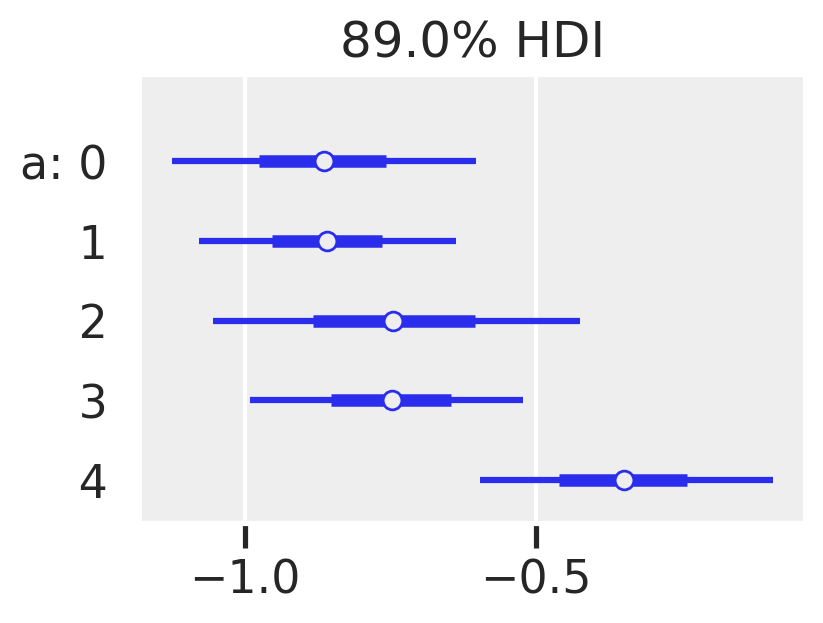

<IPython.core.display.Javascript object>

In [110]:
f, ax = plt.subplots(figsize=(4, 3))
az.plot_forest(trace_m1, combined=True, ax=ax)

In [24]:
for i in range(5):
    print(
        "pitcher: ",
        df_pitcher_code.loc[i, "pitcher"],
        "OBP estimate: ",
        expit(df_summary1.loc["a[" + str(i) + "]", "mean"]),
    )

pitcher:  ('darvish', 'yu') OBP estimate:  0.29587892279615874
pitcher:  ('musgrove', 'joe') OBP estimate:  0.29733934565526854
pitcher:  ('paddack', 'chris') OBP estimate:  0.3216935047581809
pitcher:  ('snell', 'blake') OBP estimate:  0.3212572468913136
pitcher:  ('weathers', 'ryan') OBP estimate:  0.41338242108267


<IPython.core.display.Javascript object>

Show uncertainties

# Pitcher only mixed effects model
Let's look at a mixed effects with an intercept-only model of just pitcher.

**Model `m2` equation**

$$O_i \text{ ~ } \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 3) \tag{prior for average pitcher}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of pitchers}$$

In [25]:
with pm.Model() as m2:

    # regularizing prior for average picher
    a_bar = pm.Normal("a_bar", 0, 3)

    # prior for standard deviation of pitchers
    sigma = pm.Exponential("sigma", 1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115425727322958, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6479714704882196, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6161142151956649, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

The warnings indicate divergent transitions. Let's look at the trace plots.

## Model diagnostics

array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

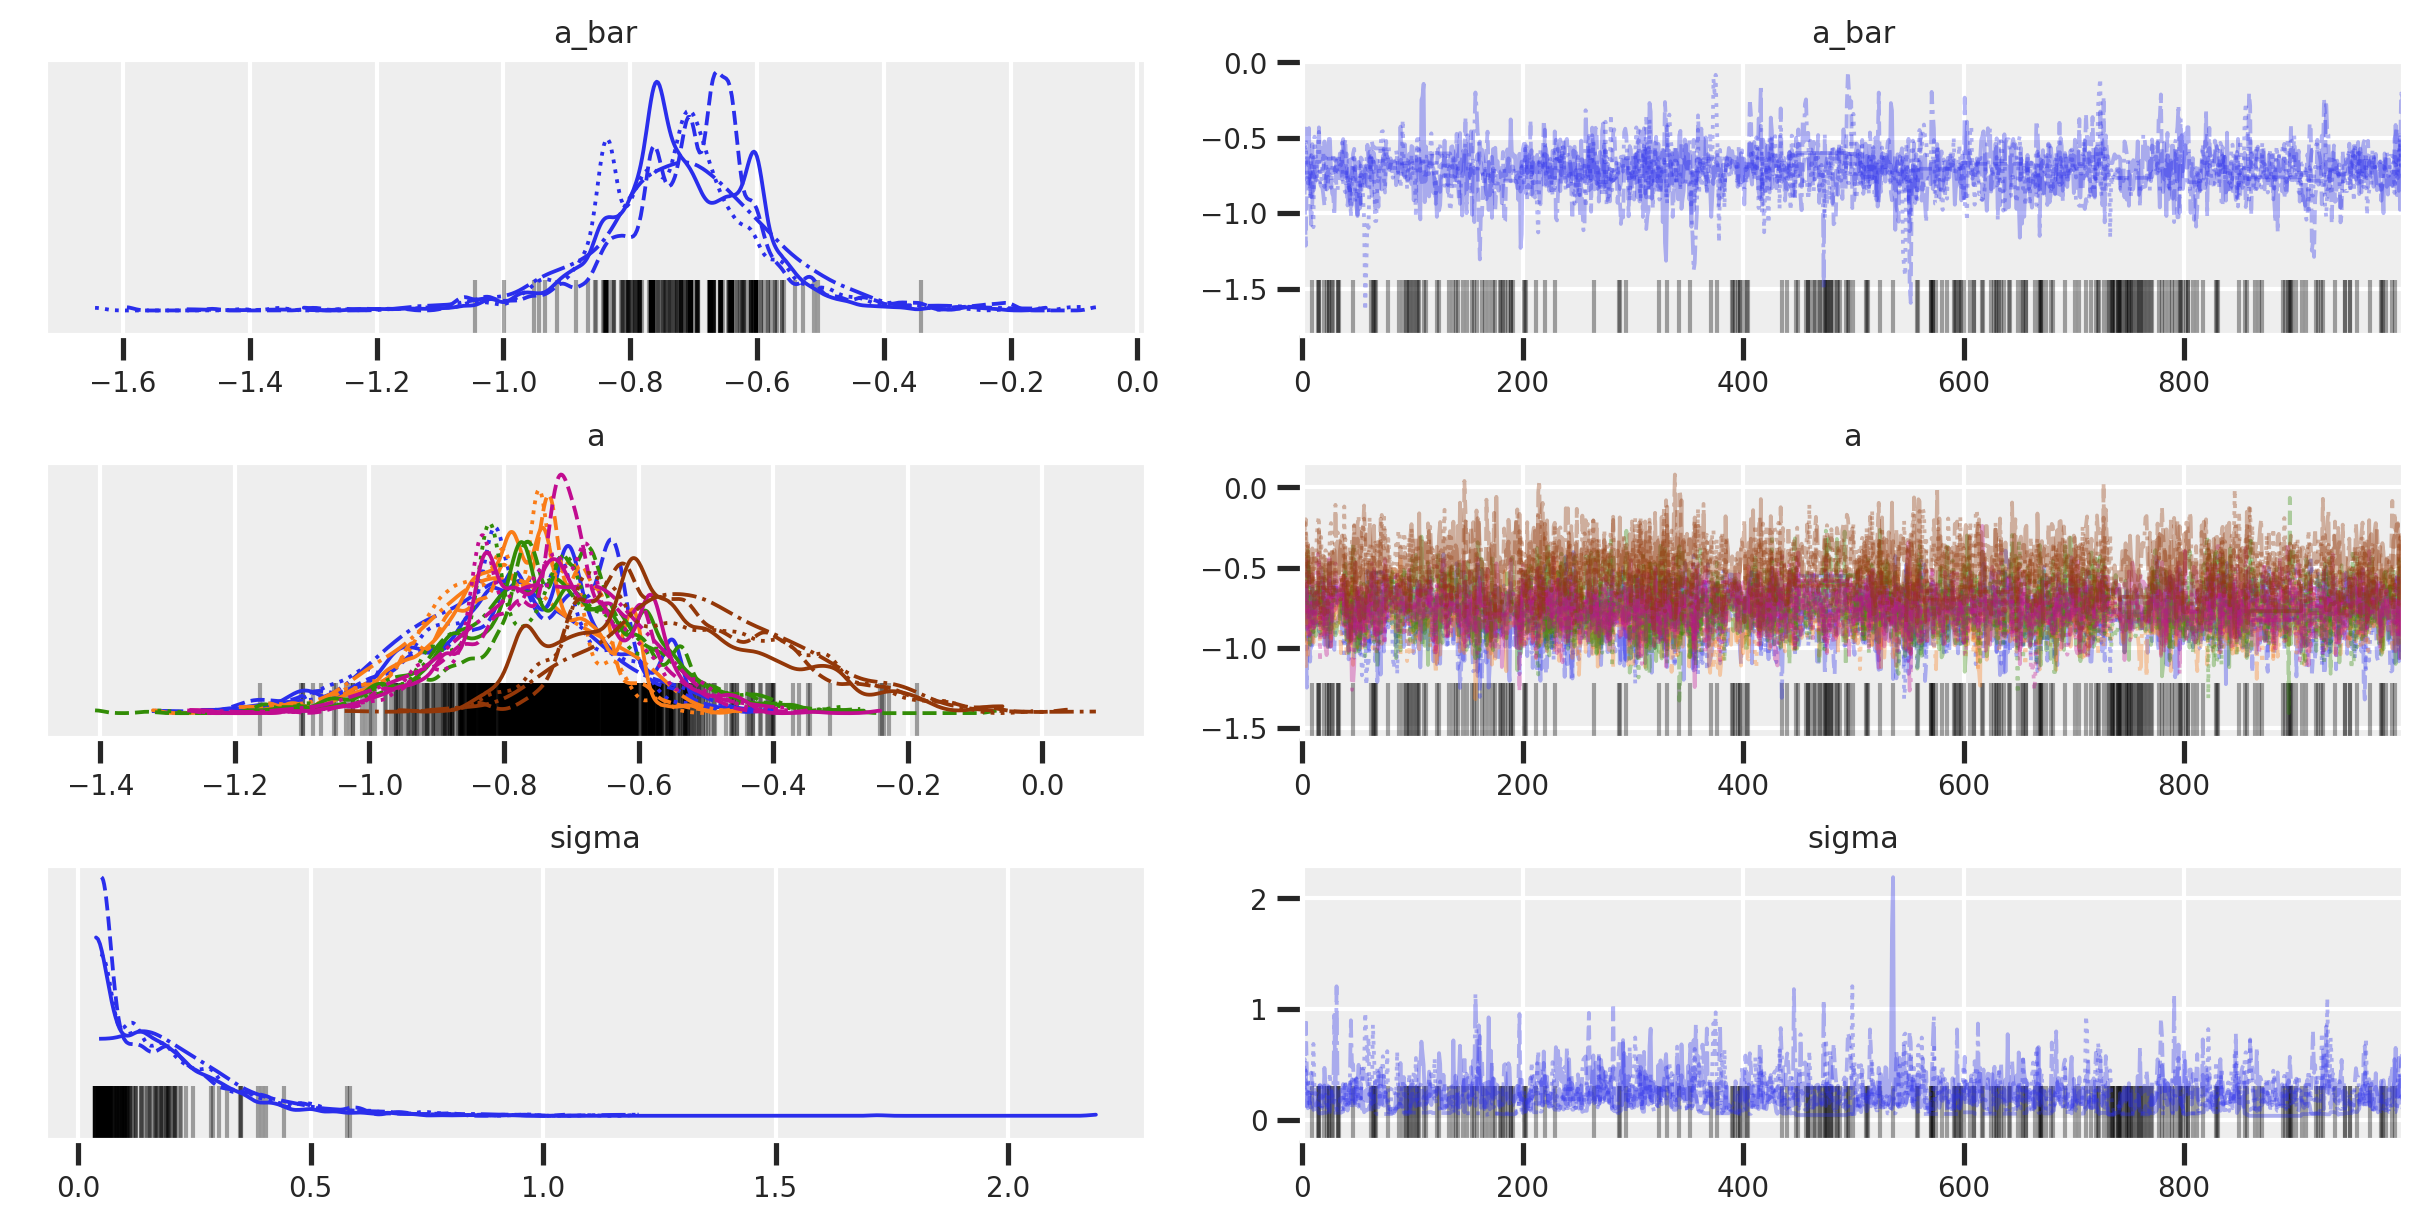

<IPython.core.display.Javascript object>

In [27]:
az.plot_trace(trace_m2)

In [65]:
az.summary(trace_m2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.716,0.138,-0.918,-0.511,0.004,0.003,1278.0,1278.0,1051.0,1854.0,1.01
a[0],-0.793,0.141,-0.995,-0.551,0.006,0.004,539.0,539.0,512.0,301.0,1.01
a[1],-0.794,0.116,-0.970,-0.605,0.005,0.004,516.0,516.0,482.0,251.0,1.01
a[2],-0.732,0.142,-0.969,-0.517,0.004,0.003,1452.0,1452.0,1369.0,2219.0,1.01
a[3],-0.734,0.124,-0.936,-0.550,0.004,0.003,1006.0,1006.0,985.0,1708.0,1.01
a[4],-0.529,0.158,-0.772,-0.291,0.009,0.007,336.0,274.0,289.0,185.0,1.01
sigma,0.210,0.162,0.036,0.394,0.009,0.006,343.0,343.0,136.0,106.0,1.02


<IPython.core.display.Javascript object>

Should I re-parameterize? The book indicates that changing `adapt_delta` (in Stan) would be a way to fix this. In pymc, I can increase the tuning.

In [29]:
with pm.Model() as m2:

    # regularizing prior for average picher
    a_bar = pm.Normal("a_bar", 0, 3)

    # prior for standard deviation of pitchers
    sigma = pm.Exponential("sigma", 1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune 
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m2 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 24 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6994494642401462, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [30]:
az.summary(trace_m2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.713,0.156,-0.904,-0.482,0.005,0.003,1017.0,1017.0,1343.0,1516.0,1.01
a[0],-0.801,0.139,-1.023,-0.583,0.004,0.003,1046.0,1046.0,1040.0,1183.0,1.00
a[1],-0.806,0.122,-1.009,-0.620,0.003,0.002,1334.0,1334.0,1313.0,790.0,1.00
a[2],-0.731,0.147,-0.963,-0.492,0.003,0.002,1922.0,1922.0,1814.0,2487.0,1.00
a[3],-0.733,0.126,-0.926,-0.528,0.003,0.002,2167.0,2144.0,2111.0,2573.0,1.00
a[4],-0.509,0.158,-0.762,-0.265,0.006,0.004,727.0,638.0,691.0,734.0,1.00
sigma,0.237,0.182,0.041,0.419,0.007,0.005,693.0,693.0,377.0,267.0,1.00


<IPython.core.display.Javascript object>

Better but still not great. Initially, I thought about re-paramaterizing and using a non-centered form. But in McElreath's text (page 407-408) he talks about some issues with using exponential priors, particularly when the number of clusters is not very high. (By coincidence, the example he used was "5 clusters" which is the same in this problem.) This number of clusters is like using 5 data points and it can make extreme values plausible for the model.

## Model with half-normal for sigma

**Model `m3` equation**

$ O_i \text{ ~ } \text{Binomial}(n_i, p_i) \tag{O for number of on-base events} $

$ \text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable} $

$ \alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior} $

$ \bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average pitcher} $

$ \sigma \text{ ~ } \text{Half-Normal}(0, 1) \tag{prior for standard deviation of pitchers} $

In [41]:
df_padres

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0
5,"('weathers', 'ryan')",2021-07-06,21,7,0.333333,Rothschild,4,0
6,"('paddack', 'chris')",2021-07-07,17,10,0.588235,Rothschild,2,0
7,"('darvish', 'yu')",2021-07-08,17,8,0.470588,Rothschild,0,0
8,"('musgrove', 'joe')",2021-07-10,21,7,0.333333,Rothschild,1,0
9,"('weathers', 'ryan')",2021-07-11,9,3,0.333333,Rothschild,4,0


<IPython.core.display.Javascript object>

In [112]:
df_padres.groupby("pitcher").sum()["n_ab"]

pitcher
('darvish', 'yu')       176
('musgrove', 'joe')     249
('paddack', 'chris')    118
('snell', 'blake')      199
('weathers', 'ryan')    167
Name: n_ab, dtype: int64

<IPython.core.display.Javascript object>

In [40]:
with pm.Model() as m3:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.25)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m3 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 16 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.652622552462576, but should be close to 0.8. Try to increase the number of tuning steps.
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49871490369005406, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 53 d

<IPython.core.display.Javascript object>

In [38]:
with pm.Model() as m4:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for standard deviation of pitchers
    sigma = pm.Lognormal("sigma", 0, 1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m4 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 20 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some 

<IPython.core.display.Javascript object>

In [42]:
with pm.Model() as m5:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.5)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m5 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 23 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 23 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6375039960089248, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6981058180061871, but s

<IPython.core.display.Javascript object>

In [89]:
# even narrower
with pm.Model() as m5:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.25)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.25)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased target accept (0.95 is already high)
    trace_m5 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=3000,
        return_inferencedata=True,
        target_accept=0.99,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 37 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

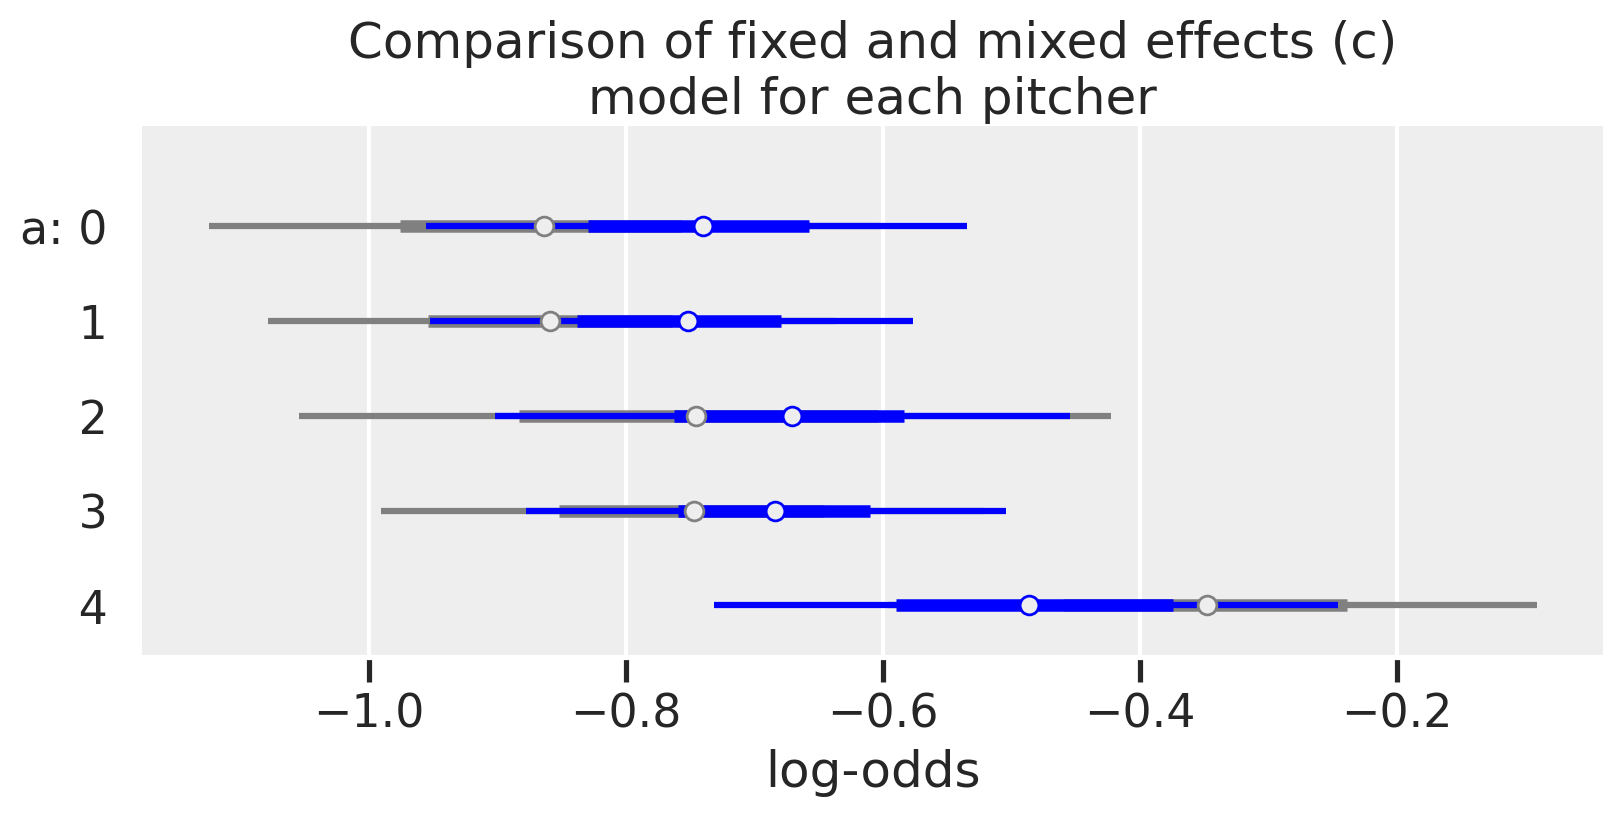

<IPython.core.display.Javascript object>

In [100]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m5,
    var_names="a",
    combined=True,
    colors="blue",
    ax=ax1,
)
ax1.set_title("Comparison of fixed and mixed effects (c)\nmodel for each pitcher")
ax1.set_xlabel("log-odds")

In [114]:
df_summary_m1 = az.summary(trace_m1)
df_summary_m2 = az.summary(trace_m2)
col2keep = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary2 = pd.merge(
    df_summary_m1[col2keep],
    df_summary_m2[col2keep],
    left_index=True,
    right_index=True,
    how="inner",
)
# Bring them in the same dataframe
# x is the fixed effects model
# y is the mixed effects model
df_summary2["vars"] = df_summary2.index
df_summary2.reset_index(drop=True, inplace=True)
df_summary2.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,-0.867,0.163,-1.125,-0.603,-0.801,0.139,-1.023,-0.583,a[0]
1,-0.860,0.139,-1.079,-0.638,-0.806,0.122,-1.009,-0.620,a[1]
2,-0.746,0.201,-1.054,-0.423,-0.731,0.147,-0.963,-0.492,a[2]
3,-0.748,0.151,-0.991,-0.522,-0.733,0.126,-0.926,-0.528,a[3]
4,-0.350,0.159,-0.596,-0.091,-0.509,0.158,-0.762,-0.265,a[4]


<IPython.core.display.Javascript object>

[(0.0, 1.0),
 (-1.0, 5.0),
 Text(0.5, 0, 'proportion predicted\nfor on-base event'),
 Text(0, 0.5, 'pitcher index')]

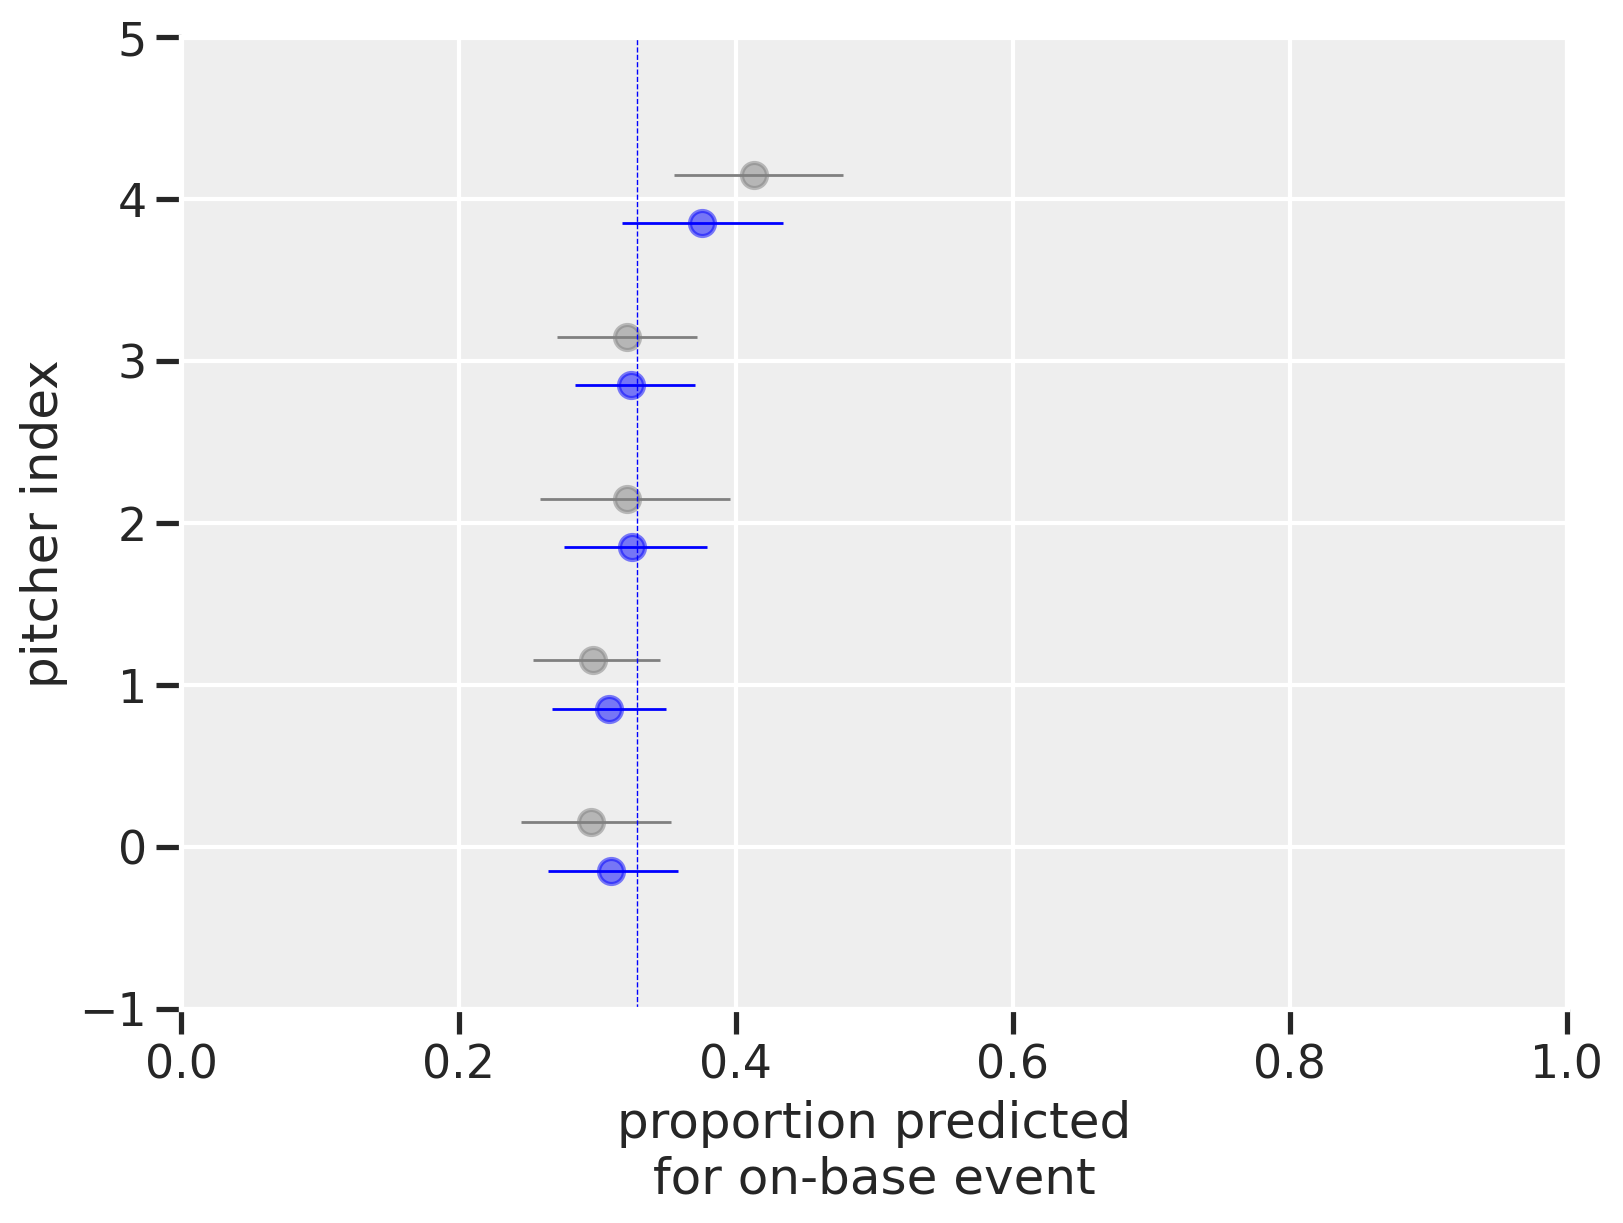

<IPython.core.display.Javascript object>

In [123]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

# Use ax1 for pitchers, ax2 for coaches
df_summary2_pitcher = df_summary2[df_summary2["vars"].str.contains("a")]
df_summary2_coach = df_summary2[df_summary2["vars"].str.contains("g")]

# Plot means
ax1.scatter(
    logistic(df_summary2_pitcher["mean_x"]),
    df_summary2_pitcher.index + 0.15,
    color="gray",
    alpha=0.5,
    label="fixed effect",
)

ax1.scatter(
    logistic(df_summary2_pitcher["mean_y"]),
    df_summary2_pitcher.index - 0.15,
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.hlines(
    y=df_summary2_pitcher.index + 0.15,
    xmin=logistic(df_summary2_pitcher["hdi_5.5%_x"]),
    xmax=logistic(df_summary2_pitcher["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
)

ax1.hlines(
    y=df_summary2_pitcher.index - 0.15,
    xmin=logistic(df_summary2_pitcher["hdi_5.5%_y"]),
    xmax=logistic(df_summary2_pitcher["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
)


# Plot average mixed effect line
me_mean = logistic(az.summary(trace_m2).loc["a_bar", "mean"])
ax1.plot(
    [me_mean, me_mean],
    [-1, 10],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
# fe_mean = df_bangladesh["use.contraception"].mean()
# ax1.plot(
#     [-10, 62],
#     [fe_mean, fe_mean],
#     color="red",
#     lw=0.5,
#     linestyle="--",
#     alpha=1,
#     label="fixed effect mean",
# )


# ax1.legend()
ax1.set(
    xlim=[0, 1],
    ylim=[-1, 5],
    xlabel="proportion predicted\nfor on-base event",
    ylabel="pitcher index",
)

# ax1.set_yticks(range(10))
# ax1.set_yticklabels(df_pitcher_code["pitcher"])

In [46]:
# going back to exponential (from Jan Christian)
with pm.Model() as m6:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.5)

    # prior for standard deviation of pitchers
    sigma = pm.Exponential("sigma", 0.5)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    trace_m6 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=3000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for som

<IPython.core.display.Javascript object>

Jan Christian suggested putting a beta prior on p. It led to me finding [this page](https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html) where I took some code.

In [45]:
def logp_ab(value):
    """ prior density, weakly informative prior"""
    return tt.log(tt.pow(tt.sum(value), -5 / 2))

<IPython.core.display.Javascript object>

In [49]:
n_pitcher

5

<IPython.core.display.Javascript object>

In [52]:
# beta prior on pi
# followed thisa
with pm.Model() as m8:

    # linear model
    p = pm.Beta("p", 1, 1)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m8 = pm.sample(
        draws=1000, random_seed=19, tune=2000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

# Non-centered?

In [ ]:
# even narrower
with pm.Model() as m5:
    
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.25)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.25)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased target accept (0.95 is already high)
    trace_m5 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=3000,
        return_inferencedata=True,
        target_accept=0.99,
    )

## Re-paramaterized model

In [63]:
with pm.Model() as m9:

    # z is a variable to transform within the linear model
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # adaptive prior learns across pitchers
    # this is the variable that's transformed
    # instead of substituting, we'll use this in linear model
    # a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma)  # non-centered version

    # linear model
    p = pm.math.invlogit(a_bar + a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m9 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, z]
INFO:pymc3:NUTS: [sigma, a_bar, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [64]:
az.summary(trace_m9)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],-0.369,0.768,-1.588,0.893,0.018,0.013,1918.0,1805.0,1910.0,2208.0,1.0
z[1],-0.412,0.741,-1.561,0.737,0.018,0.012,1760.0,1760.0,1739.0,2086.0,1.0
z[2],-0.087,0.778,-1.336,1.153,0.017,0.014,2222.0,1644.0,2180.0,2408.0,1.0
z[3],-0.100,0.750,-1.222,1.120,0.018,0.014,1760.0,1512.0,1748.0,2118.0,1.0
z[4],0.875,0.802,-0.309,2.161,0.020,0.014,1600.0,1600.0,1624.0,2202.0,1.0
a_bar,-0.357,0.072,-0.461,-0.251,0.003,0.002,684.0,654.0,843.0,763.0,1.0
sigma,0.233,0.197,0.001,0.441,0.009,0.006,508.0,484.0,573.0,765.0,1.0
a[0],-0.442,0.140,-0.655,-0.228,0.003,0.002,1623.0,1589.0,1693.0,2176.0,1.0
a[1],-0.447,0.126,-0.636,-0.247,0.003,0.002,1769.0,1764.0,1811.0,2475.0,1.0
a[2],-0.377,0.144,-0.603,-0.141,0.003,0.002,2167.0,2162.0,2306.0,2124.0,1.0


<IPython.core.display.Javascript object>

### Comparison of fixed-effects and mixed-effects models

Text(0.5, 0, 'log-odds')

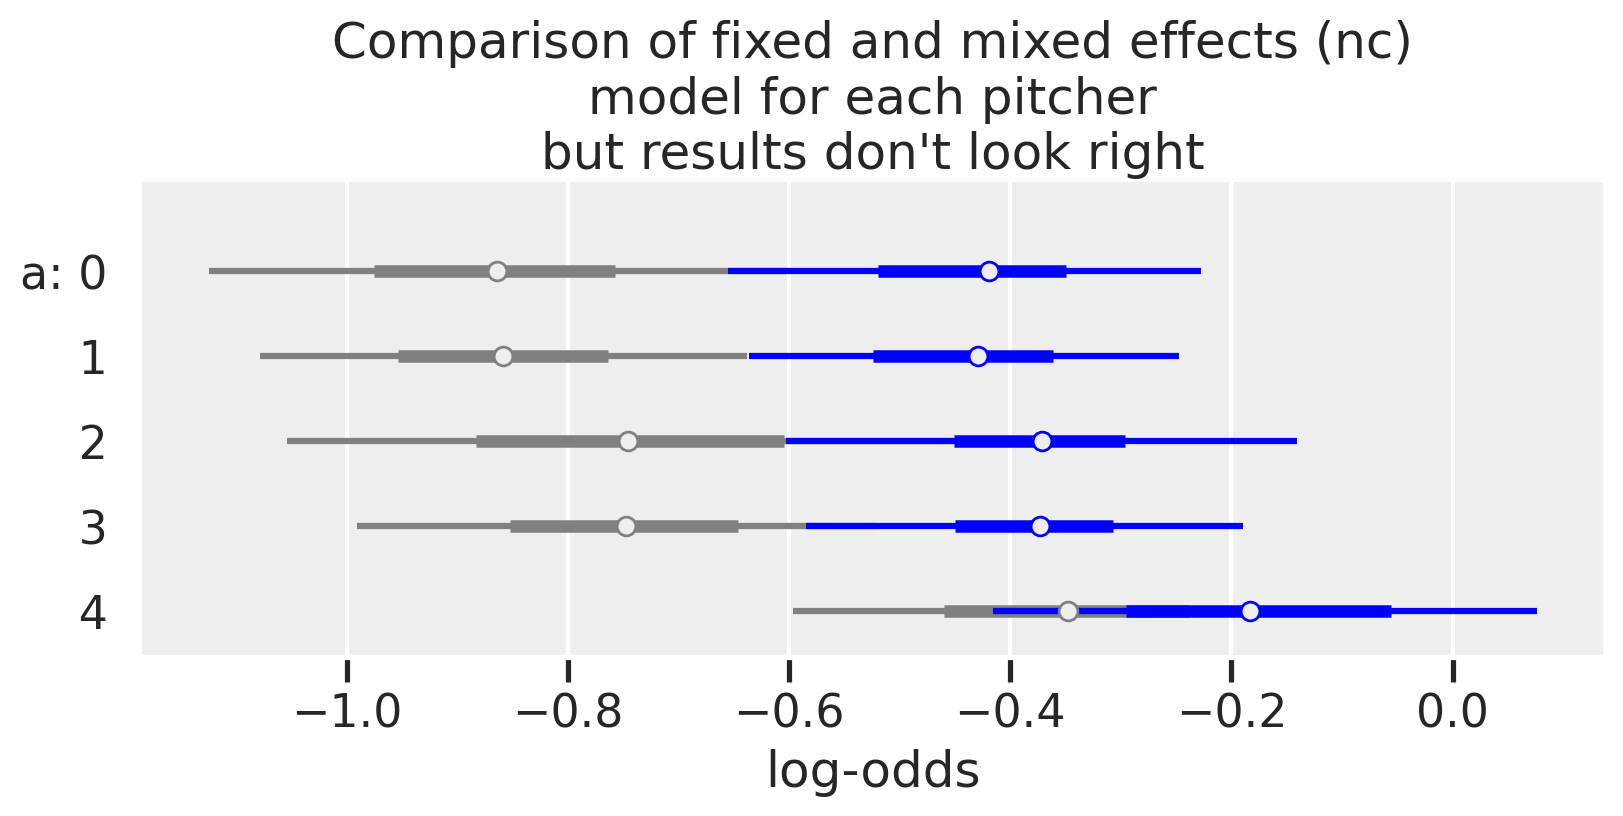

<IPython.core.display.Javascript object>

In [104]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

# For plotting decoration
kwg = {"label": "mixed"}
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m9,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title(
    "Comparison of fixed and mixed effects (nc)\nmodel for each pitcher\nbut results don't look right"
)
ax1.set_xlabel("log-odds")

In [107]:
with pm.Model() as m9a:

    # z is a variable to transform within the linear model
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # moved df_padres["pitcher_code"] to here
    a = pm.Deterministic(
        "a", a_bar + z[df_padres["pitcher_code"]] * sigma
    )  # non-centered version

    # linear model
    p = pm.math.invlogit(a_bar + a)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m9a = pm.sample(
        draws=1000,
        random_seed=19,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, z]
INFO:pymc3:NUTS: [sigma, a_bar, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [109]:
az.summary(trace_m9a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],-0.356,0.764,-1.518,0.880,0.016,0.013,2301.0,1797.0,2285.0,2464.0,1.00
z[1],-0.416,0.752,-1.620,0.740,0.017,0.012,1950.0,1843.0,1928.0,2458.0,1.00
z[2],-0.071,0.775,-1.332,1.107,0.015,0.013,2717.0,1754.0,2679.0,2654.0,1.00
z[3],-0.082,0.728,-1.200,1.114,0.016,0.013,2093.0,1650.0,2071.0,2453.0,1.00
z[4],0.912,0.792,-0.352,2.150,0.018,0.013,1841.0,1841.0,1828.0,2121.0,1.00
a_bar,-0.356,0.071,-0.475,-0.256,0.002,0.001,1171.0,1171.0,1242.0,1052.0,1.00
sigma,0.232,0.175,0.000,0.442,0.006,0.005,737.0,737.0,683.0,957.0,1.01
a[0],-0.161,0.162,-0.417,0.068,0.004,0.003,1496.0,1399.0,1402.0,2525.0,1.01
a[1],-0.376,0.144,-0.608,-0.158,0.002,0.002,3325.0,3208.0,3369.0,3191.0,1.00
a[2],-0.444,0.140,-0.662,-0.232,0.003,0.002,2181.0,2046.0,2238.0,2393.0,1.00


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

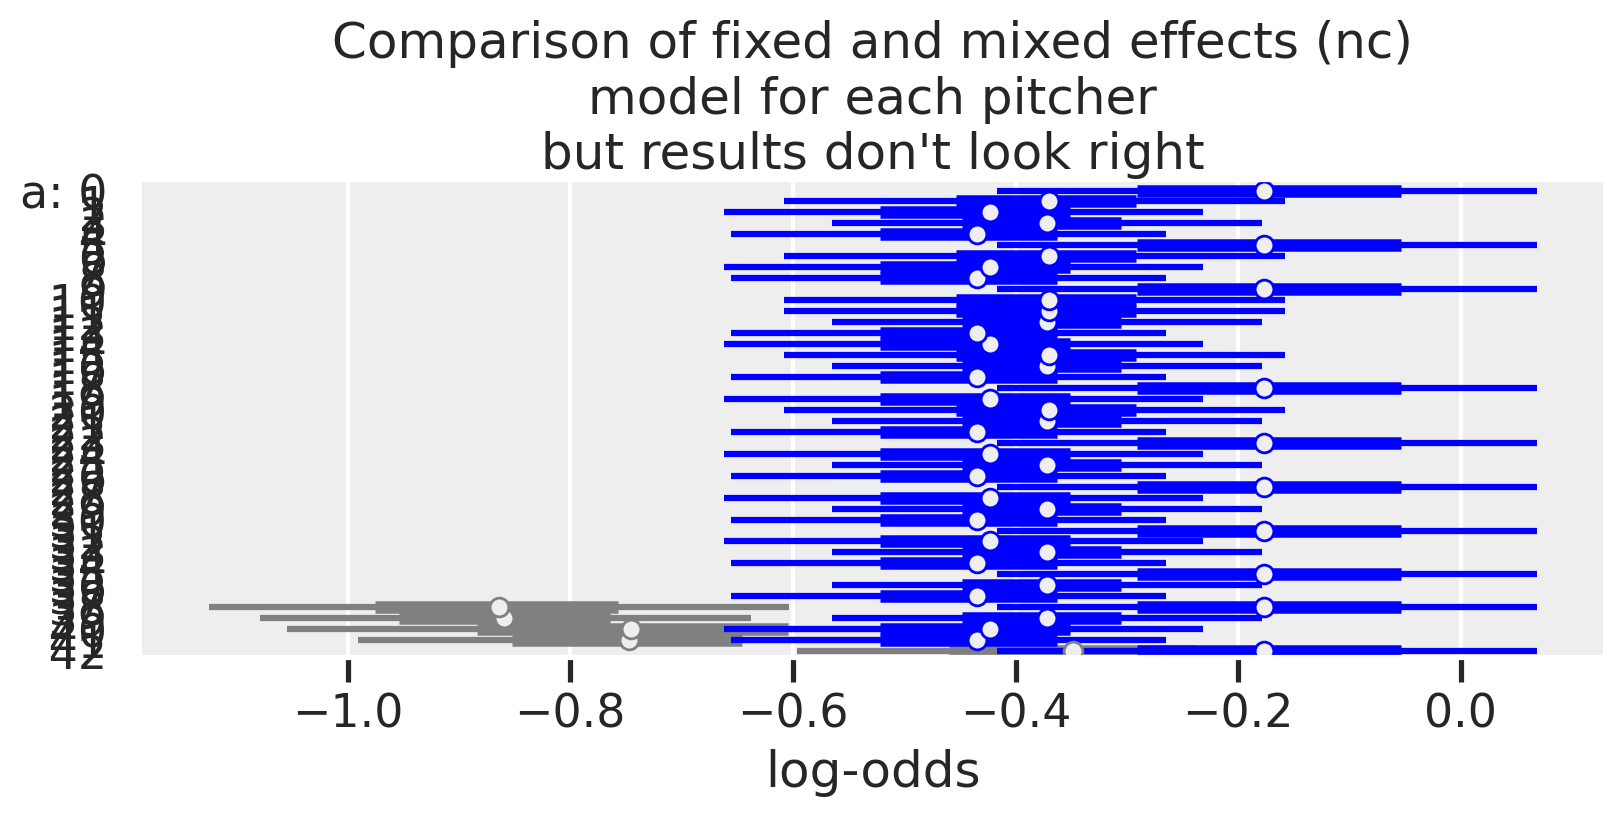

<IPython.core.display.Javascript object>

In [108]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m9a,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title(
    "Comparison of fixed and mixed effects (nc)\nmodel for each pitcher\nbut results don't look right"
)
ax1.set_xlabel("log-odds")

## Other tests of re-paramaterized model

In [ ]:
with pm.Model() as m9:

    # z is a variable to transform within the linear model
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # adaptive prior learns across pitchers
    # this is the variable that's transformed
    # instead of substituting, we'll use this in linear model
    # a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma)  # non-centered version

    # linear model
    p = pm.math.invlogit(a_bar + a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m9 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

In [101]:
# Looked at repo code for R 13.29
with pm.Model() as m10:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma = pm.HalfNormal("sigma", sigma=1)
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    _ = pm.Deterministic(
        "a", a_bar + z * sigma
    )  # non-centered version, but not being used

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m10 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
INFO:pymc3:NUTS: [z, sigma, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [103]:
az.summary(trace_m10)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.708,0.139,-0.914,-0.499,0.005,0.004,736.0,736.0,858.0,785.0,1.01
z[0],-0.415,0.757,-1.643,0.749,0.018,0.012,1841.0,1841.0,1803.0,1923.0,1.00
z[1],-0.418,0.741,-1.542,0.756,0.018,0.013,1610.0,1610.0,1596.0,2399.0,1.00
z[2],-0.076,0.780,-1.276,1.211,0.017,0.013,2154.0,1747.0,2131.0,2485.0,1.00
z[3],-0.104,0.758,-1.302,1.107,0.015,0.012,2420.0,1966.0,2418.0,2582.0,1.00
z[4],0.857,0.808,-0.357,2.174,0.020,0.014,1712.0,1699.0,1688.0,1890.0,1.00
sigma,0.227,0.178,0.001,0.424,0.007,0.005,631.0,631.0,652.0,923.0,1.01
a[0],-0.801,0.132,-1.007,-0.594,0.002,0.002,2987.0,2987.0,2913.0,3574.0,1.00
a[1],-0.802,0.120,-0.971,-0.586,0.002,0.002,2924.0,2924.0,2870.0,3634.0,1.00
a[2],-0.732,0.147,-0.955,-0.493,0.003,0.002,3449.0,3292.0,3579.0,2655.0,1.00


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

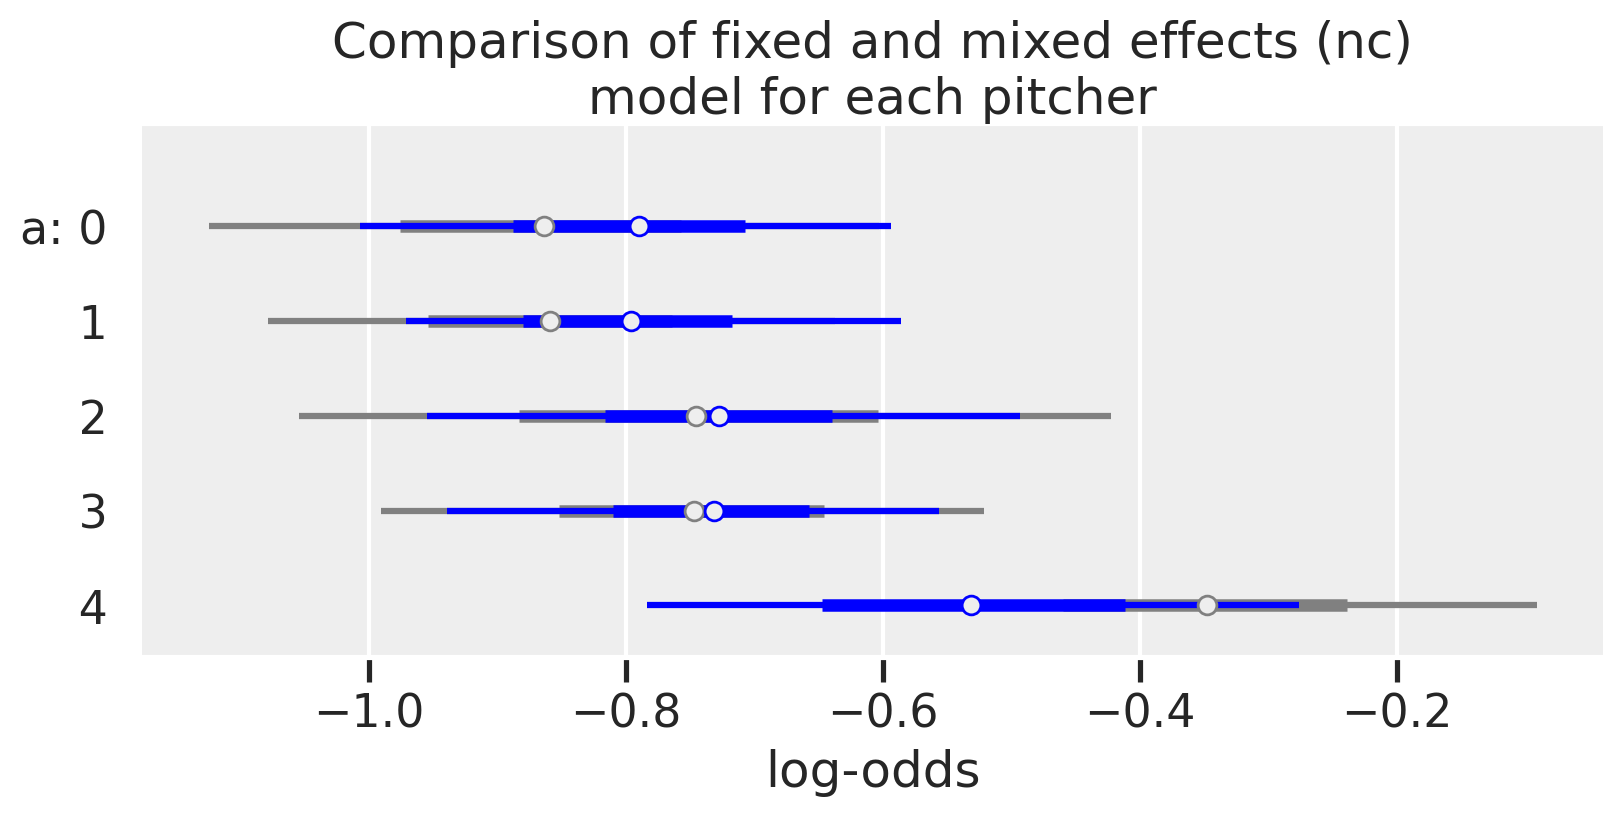

<IPython.core.display.Javascript object>

In [102]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

# For plotting decoration
kwg = {"label": "mixed"}
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m10,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title("Comparison of fixed and mixed effects (nc)\nmodel for each pitcher")
ax1.set_xlabel("log-odds")

Text(0.5, 0, 'log-odds')

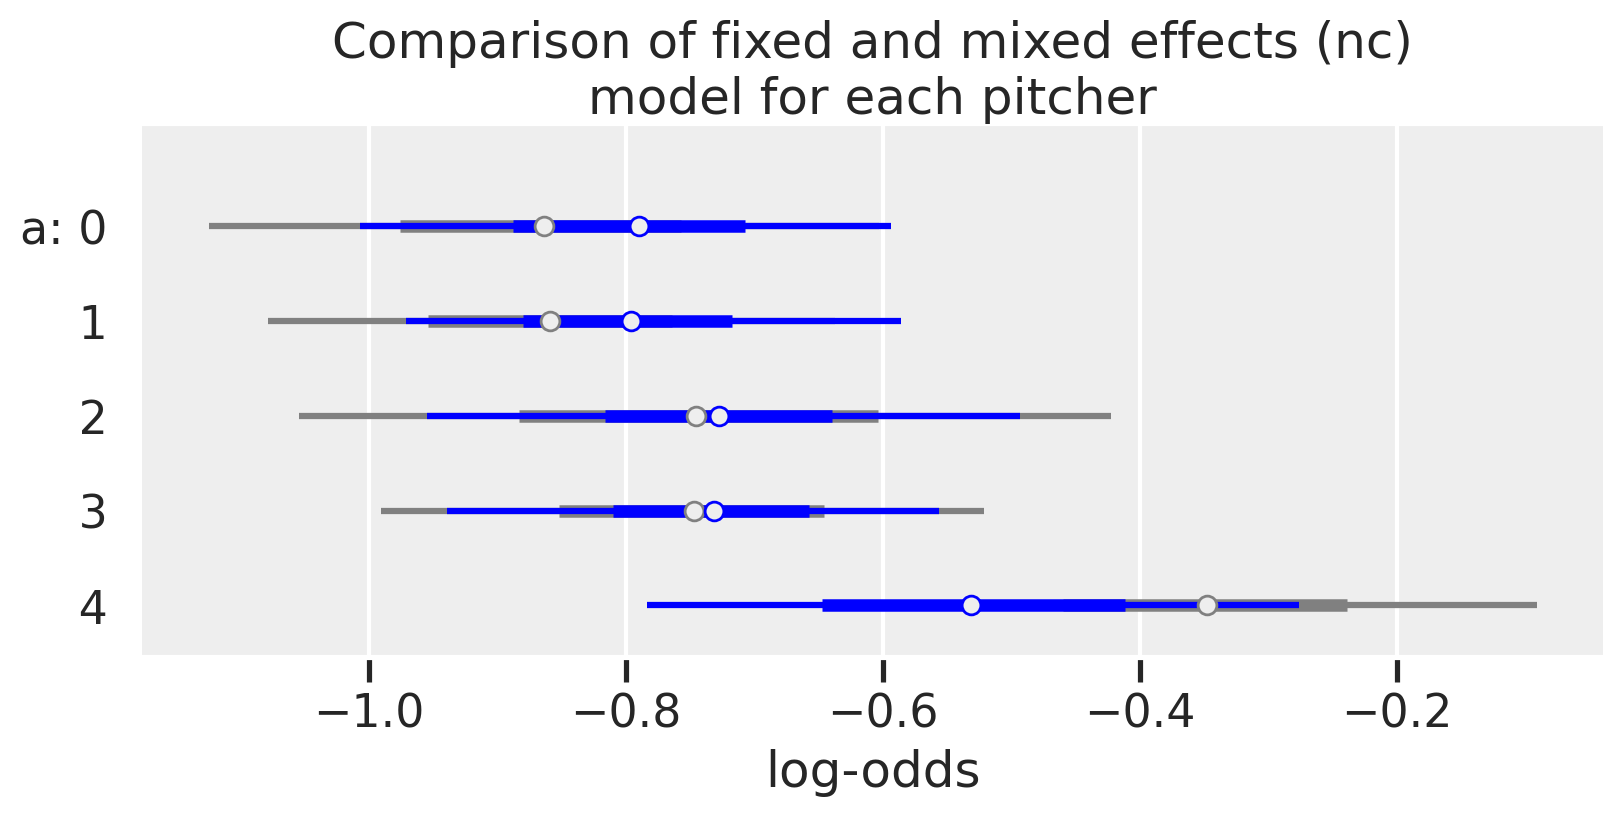

<IPython.core.display.Javascript object>

In [105]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

# For plotting decoration
kwg = {"label": "mixed"}
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m10,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title("Comparison of fixed and mixed effects (nc)\nmodel for each pitcher")
ax1.set_xlabel("log-odds")

In [61]:
# Looked at repo code for R 13.29
with pm.Model() as m11:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma = pm.Exponential("sigma", 1)
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    _ = pm.Deterministic(
        "a", a_bar + z * sigma
    )  # non-centered version, but not being used

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m11 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
INFO:pymc3:NUTS: [z, sigma, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

Thank you Jan ... I initially found this intimidating but think got something working. It took quite a few steps but it started to make sense after re-reading section 13.4.

Here is what I did, starting from the centered version of the model (what I had shown above). I'm using`pymc` for context. This might be TMI but maybe it's helpful for someone to see what I tried.

a. Used a Half-Normal prior for sigma based on McElreath's Overthinking box at bottom of page 407. Result: Divergences.
b. Increased `tune` to 2000 from default of 1000. (Tune is analogous to warm-up). Result: Divergences.
c. Increased `target_accept` to 0.95. (Analogous to Stan's `adapt_delta`). Result: Divergences.
d. Did both a, b, and c. Result: Divergences.
e. Made a non-centered version but only with a (Half-Normal prior0 but used defaults for b and c (This is the step I had to review a lot but adapted example from page 424.) Result: Divergences.
f. Did all above. Result: No divergences finally! (But number of effective samples is smaller than 25% for some parameters. I also tried an Exponential prior and divergences came back.)

Try doing beta binomial? From Jan:

> But if you skip the logit step and straight up puts a beta prior on p then it works with no divergences, right?, The divergences arise because of the tails of the normal distribution is giving high probability mass to very high and low probabilities after transforming via the logic link function and because of the conditional dependence of the parameters in the model specification... Right?

In [ ]:
with pm.Model() as m_13_4nc:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0.0, 1.0, shape=Nactor)
    x = pm.Normal("x", 0.0, 1.0, shape=Nblock)
    b = pm.Normal("b", 0.0, 0.5, shape=Ntreatments)

    _ = pm.Deterministic("a", a_bar + z * sigma_a)  # actor intercepts
    _ = pm.Deterministic("g", x * sigma_g)  # block intercepts
    p = pm.math.invlogit(a_bar + z[actor] * sigma_a + x[block] * sigma_g + b[treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_13_4nc = pm.sample(tune=3000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_13_4nc = az.from_pymc3(trace_13_4nc)

**Model `m3` equation**

$$O_i \text{ ~ } \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 3) \tag{prior for average pitcher}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of pitchers}$$

In [35]:
with pm.Model() as m3:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m3 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 16 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6807644133779827, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

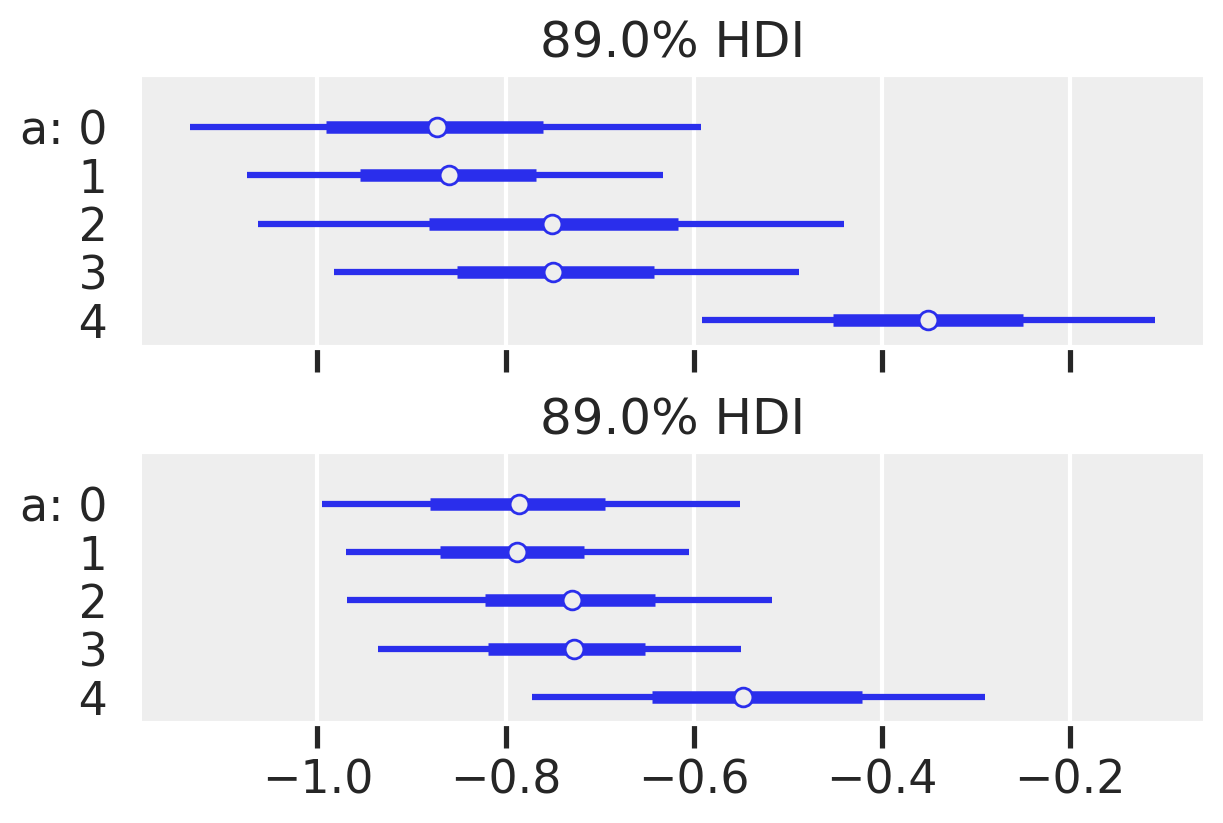

<IPython.core.display.Javascript object>

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(trace_m1, var_names=["a"], combined=True, ax=ax1)
az.plot_forest(trace_m2, var_names=["a"], combined=True, ax=ax2)

In [ ]:
# modified from repo
with pm.Model() as m_13_2:
    # adaptive prior
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # adaptive prior
    a = pm.Normal("a", a_bar, sigma, shape=n_tanks)

    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

# Coach only fixed effects model

**Model `m3` equation**

$$O_i \text{ ~ } \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{COACH}[i]} \tag{coach is encoded as an index variable}$$

$$\alpha_j \text{ ~ } \text{Normal}(0, 2) \tag{regularizing prior for each pitcher}$$

In [20]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0


<IPython.core.display.Javascript object>

In [21]:
n_coach

2

<IPython.core.display.Javascript object>

In [22]:
# modified from repo
with pm.Model() as m3:
    # regularizing prior
    a = pm.Normal("a", 0.0, 2, shape=n_coach)
    # linear model
    p = pm.math.invlogit(a[df_padres["pitching_coach_code"]])
    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])
    # sample
    trace_m3 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [23]:
az.summary(trace_m3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.653,0.073,-0.763,-0.533,0.001,0.001,3671.0,3671.0,3661.0,2748.0,1.0
a[1],-1.433,0.259,-1.825,-0.987,0.004,0.003,3572.0,3418.0,3605.0,2603.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

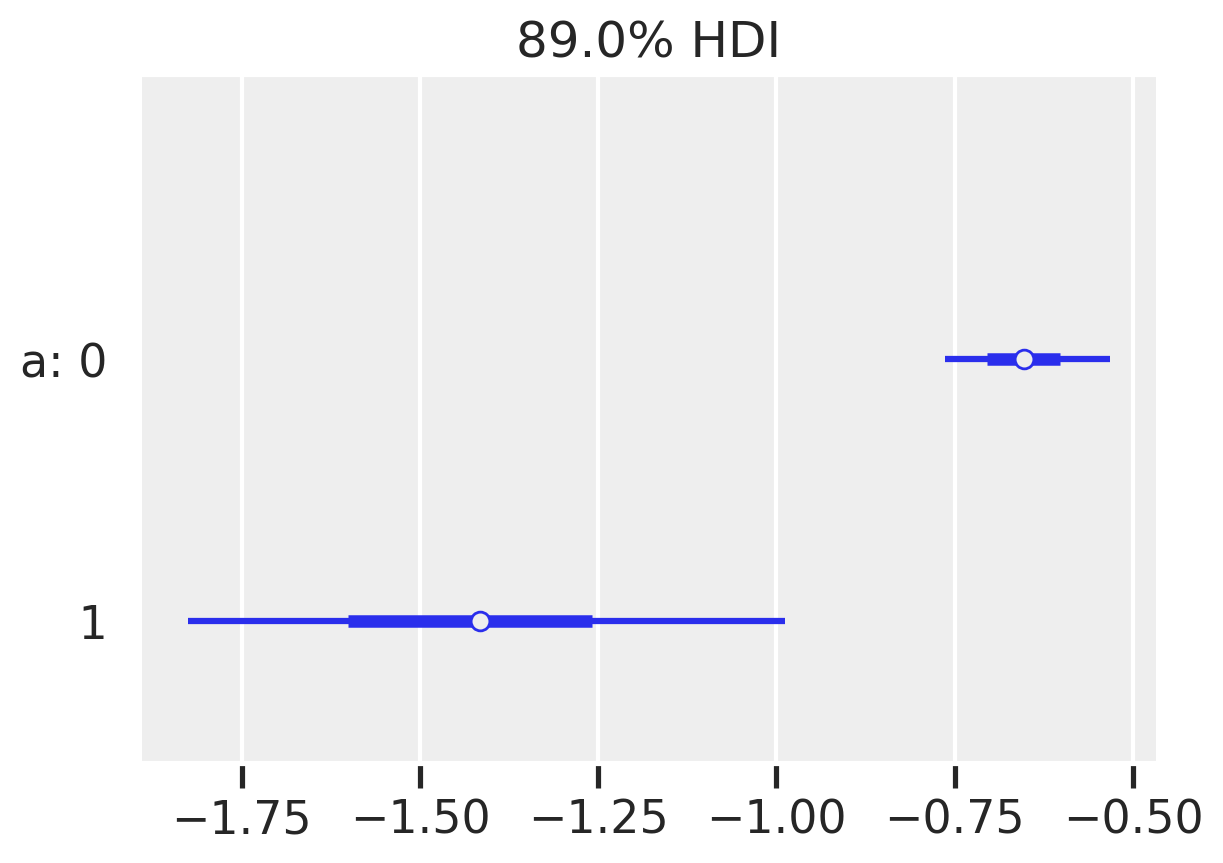

<IPython.core.display.Javascript object>

In [24]:
az.plot_forest(trace_m3, combined=True)

# Coach only mixed effects model
Let's look at a mixed effects with an intercept-only model of just coach.

**Model `m4` equation**

$$O_i \text{ ~ } \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{COACH}[i]} \tag{coach is encoded as an index variable}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 2) \tag{prior for average coach}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of coaches}$$

In [25]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0


<IPython.core.display.Javascript object>

In [27]:
with pm.Model() as m4:

    # regularizing prior for average coach
    a_bar = pm.Normal("a_bar", 0, 2)

    # prior for standard deviation of coachs
    sigma = pm.Exponential("sigma", 1)

    # addaptive prior learns across coachs
    a = pm.Normal("a", a_bar, sigma, shape=n_coach)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitching_coach_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m4 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6351641315439731, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

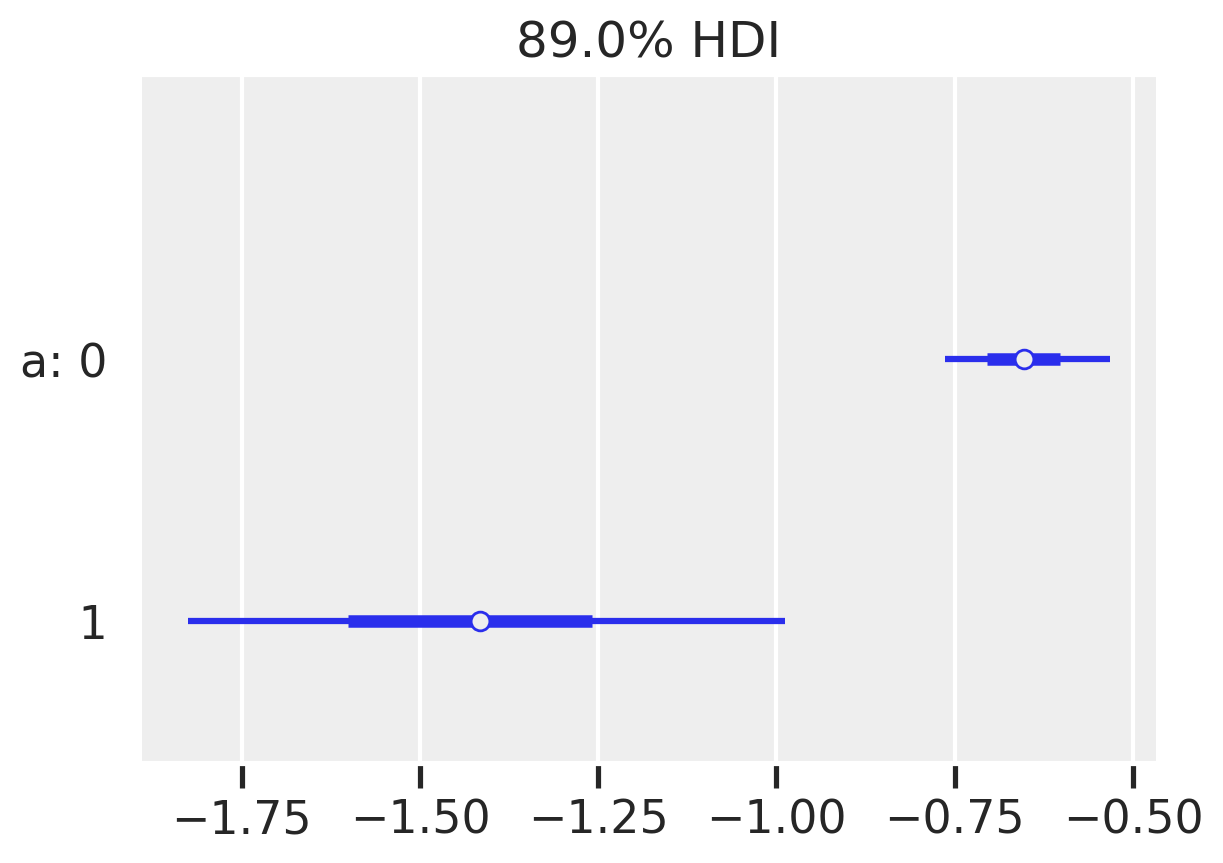

<IPython.core.display.Javascript object>

In [30]:
az.plot_forest(trace_m3, var_names=["a"], combined=True)

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

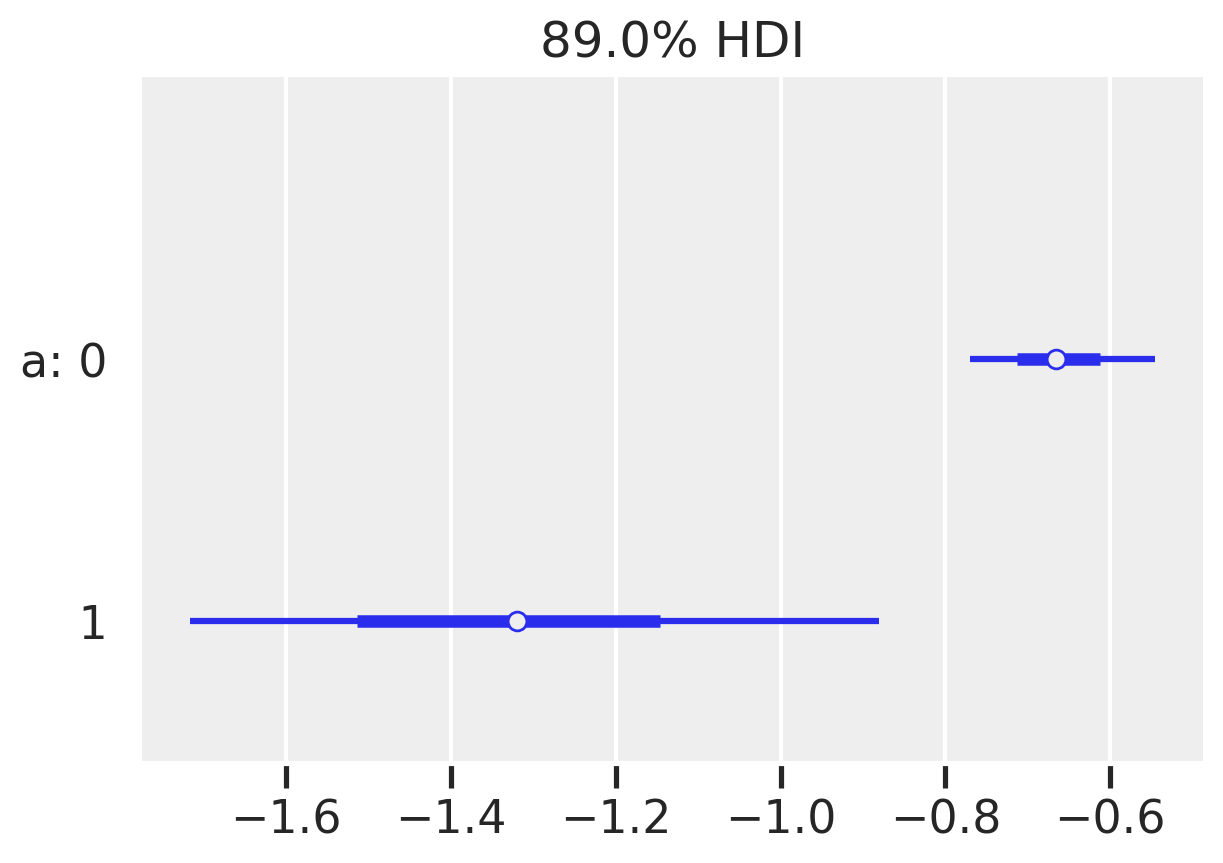

<IPython.core.display.Javascript object>

In [29]:
az.plot_forest(trace_m4, var_names=["a"], combined=True)

# Next step: plot both pitcher and coach clusters

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>